# 🌎Earthquakes Prediction🌍with RNNs🌏

### Author: Victor Manuel Fonte Chavez

## Problem Description:

In this project, data was taken from earthquake readings around the world during the month of April 2023 to predict the location and magnitude of the next 10 earthquakes. It should be noted that these data are not regularly spaced in time, so interpolation will be required to obtain a well-defined time series. However, this step will be skipped this time because the data is very spread out over short periods of time, making it difficult to get accurate data over a certain distance without adding too much bias to the data.

Consequently, it has been decided to approach the problem in the following way: obtain a model that allows to approximately predict the latitude and longitude of the next earthquake with a scale greater than 4.5 in the world. For this, the data of the earthquakes of the same magnitude that occurred in the month of April will be taken into account, in addition to the estimated magnitude of the earthquake to be predicted.

## Methodology

It will begin with a descriptive analysis of the data to better understand its characteristics and detect possible patterns or trends. Then, we will move on to the construction of recurrent neural network models that allow us to predict the latitude and longitude of the next earthquake of magnitude greater than 4.5 in the world.

First, a model will be built based on LSTM (Long Term Memory Neural Networks), a neural network architecture that allows learning patterns of data sequences and remembering relevant information in the long term. Then, another model that uses Vanilla RNN (Standard Recurrent Neural Networks) layers will be experimented to compare its performance with the LSTM model.

Subsequently, we will continue with a model that uses GRU layers (Gated Recurrent Units), a variant of recurrent neural networks that focuses on handling relevant information and discarding redundant information.

Finally, bidirectional layers will be added to the LSTM architecture, allowing the neural network to take into account both the past and the future of the data stream to make a more accurate prediction.

With this methodology, different recurrent neural network architectures will be compared and find the one that best fits your data to make accurate predictions of the next earthquakes of magnitude greater than 4.5.


## Table of Contents 
    
1. [IMPORTING LIBRARIES](#1)
    
2. [LOADING DATA](#2)

3. [INFORMATIVE DATA VISUALIZATIONS](#3)
    
4. [DATA PREPROCESSING](#4) 
      
5. [MODEL SELECTION AND TRAINING](#5)

    a). [LSTM](#a)
    
    b). [VANILLA RNN](#b)
    
    c). [GRU](#c)
    
    d). [BIDIRECTIONAL LSTM](#d)
    
6. [EVALUATING MODELS](#6)

    
    
<a id="1"></a>
# 1. Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import os, shutil

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from keras.layers import Activation, Dropout, Reshape
from keras.optimizers import Adam, Nadam, RMSprop
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [4]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14
plt.style.use('ggplot')

<a id="2"></a>
# 2. Data loadin:

It begins by downloading the data and the variables of interest to be predicted are selected. Since the objective of the problem is to find a model that predicts the position and magnitude of the next 10 major earthquakes at scale 4.5, the variables `latitude`, `longitude`, `mag`, `depth` are chosen.

In [6]:
df = pd.read_csv('/kaggle/input/usgs-all-earthquakes-april-2023/4.5_month.csv')

df = df[['time', 'latitude', 'longitude', 'mag', 'depth']]


df['time'] = pd.to_datetime(df['time'])

df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.set_index('time')

df = df.sort_index()

df = df[~df.index.duplicated(keep='first')]

df.index = pd.DatetimeIndex(df.index)

df

,latitude,longitude,mag,depth
time,,,,
2023-04-08 06:58:16,1.9123,127.1046,4.8,100.508
2023-04-08 07:17:42,51.7196,-175.3241,4.5,55.097
2023-04-08 07:38:46,-28.5261,-177.7762,4.6,10.000
2023-04-08 08:07:23,-41.1394,-86.3095,4.6,10.000
2023-04-08 11:06:11,9.1273,93.9306,4.6,8.194
...,...,...,...,...
2023-05-07 21:53:02,-24.2777,-179.3706,5.0,546.210
2023-05-08 00:51:56,-2.7180,-78.9691,5.2,92.501
2023-05-08 02:34:02,-28.6913,-71.3262,4.6,37.684


In [6]:
df_original = df.copy()

<a id="3"></a>
# 3. Informative data visualizations:

We will graph the data to observe the temporal structure of the data. As can be seen, the last two graphs present quite high data, with respect to the others. This is unlike the first two graphs. It would not be correct to observe non-stationarity patterns, since this property is not needed for modeling with neural networks.

array([<AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>,
       <AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>],
      dtype=object)

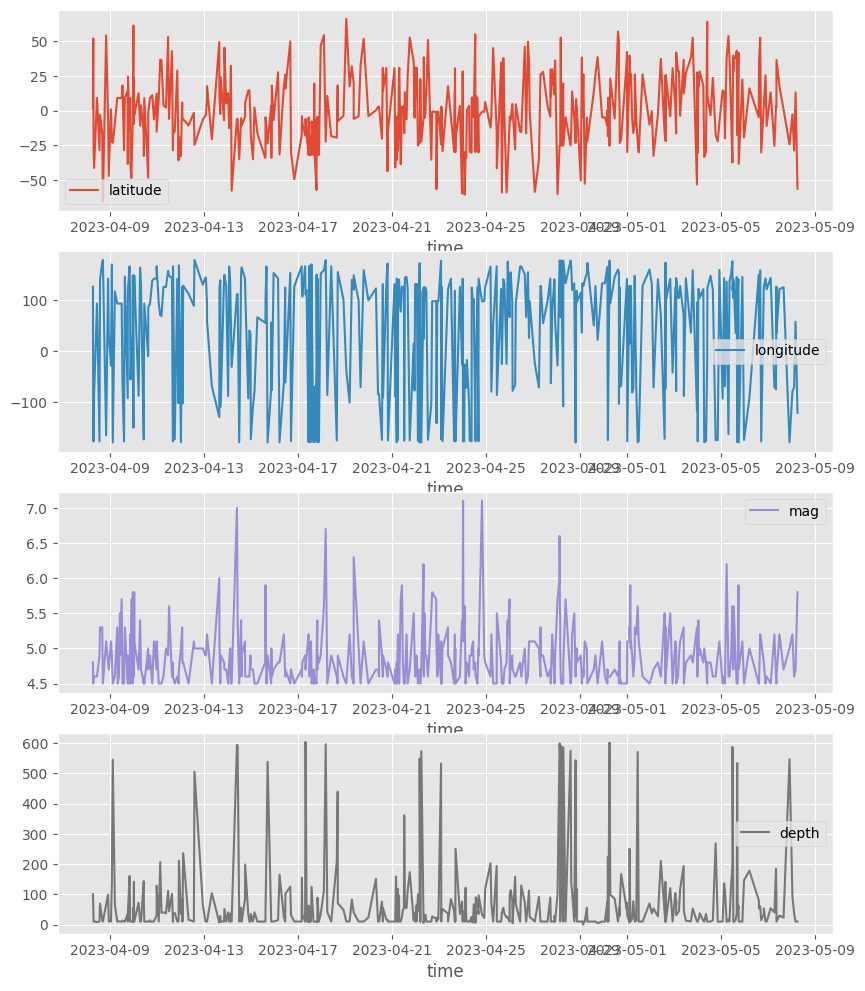

In [7]:
df.plot(subplots=True, figsize=(10, 12), sharex=False, sharey=False)

In [7]:
df.describe()

,latitude,longitude,mag,depth
count,452.000000,452.000000,452.000000,452.000000
mean,-0.751835,42.206556,4.878761,72.182954
std,26.291870,123.762853,0.418624,128.076583
min,-65.210500,-179.838700,4.500000,0.000000
25%,-20.314425,-73.033825,4.600000,10.000000
50%,-3.434700,99.814350,4.800000,22.827000
75%,17.514250,140.782950,5.100000,70.099000
max,65.818000,179.978900,7.100000,603.290000


Now we will graph the simple autocorrelations function of the variables that make up df, each graph with a title, no larger than 10x4 in size and with 50 lags. It can be seen that they only present autocorrelation with one step back in the past, autocorrelation of almost 1

Text(0.5, 1.0, 'depth')

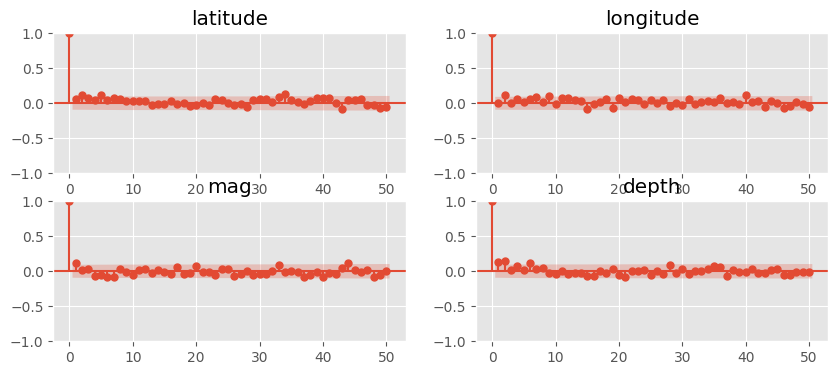

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
plot_acf(df['latitude'], ax=ax[0, 0], lags=50, title='latitude')
ax[0, 0].set_title('latitude')
plot_acf(df['longitude'], ax=ax[0, 1], lags=50, title='longitude')
ax[0, 1].set_title('longitude')
plot_acf(df['mag'], ax=ax[1, 0], lags=50, title='mag')
ax[1, 0].set_title('mag')
plot_acf(df['depth'], ax=ax[1, 1], lags=50, title='depth')
ax[1, 1].set_title('depth')



<a id="4"></a>
# 4.Data Preprocessing 

In this section we will divide the data into the training and test set, in addition to creating the structure of the data so that it is readable by the recurrent network models.

In [9]:
train = df.iloc[:442]
test = df.iloc[442 - 12:]
test_original = df.iloc[442:]

We create a generator with 12 lags, which means this:
1. The first observation of the target set is fixed
2. The 12 observations prior to it are taken
3. Iterates over the entire data set

The following output of the first value of the generator represents it

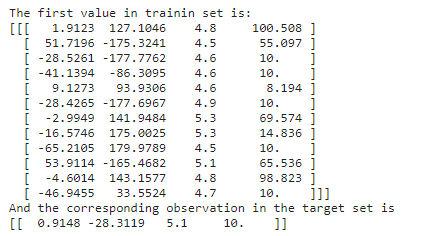

In [11]:
n_input = 12
n_features = 4
batch_size = 1

train_generator = TimeseriesGenerator(train.values, train.values,
                                        length=n_input, batch_size=batch_size)
test_generator = TimeseriesGenerator(test.values, test.values,
                                    length=n_input, batch_size=batch_size)

Finally we do it on the entire data set

In [12]:
#cargar todos los datos del generador en x,y
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])
for i in range(len(train_generator)):
    a, b = train_generator[i]
    train_x = np.append(train_x, a.flatten())
    train_y = np.append(train_y, b)
for i in range(len(test_generator)):
    a, b = test_generator[i]
    test_x = np.append(test_x, a.flatten())
    test_y = np.append(test_y, b)
    
train_x = train_x.reshape(-1, n_features, n_input)
train_y = train_y.reshape(-1, n_features)
test_x = test_x.reshape(-1, n_features, n_input)
test_y = test_y.reshape(-1, n_features)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(430, 4, 12) (430, 4)
(10, 4, 12) (10, 4)


<a id="5"></a>
# 5. Model Selection and Training:

<a id="a"></a>
### a) Definicion del modelo LSTM:

LSTM (Long Short-Term Memory) networks are a type of recurrent neural network used to process sequential data such as text or speech. Unlike traditional recurrent neural networks, LSTM networks have a more complex structure that allows them to remember information over long periods of time and avoid the problem of vanishing gradients.

The structure of an LSTM cell consists of three gates (input, forget, output) and a memory cell that are used to process input data and update long-term memory. The memory cell is updated through a weighted operation between the current input, the previous memory, and the output of the forget gate. The weighted operation is performed through a series of linear transformation layers and activation functions.

A detailed description of each component of the LSTM cell is provided below:

Input gate:
The input gate is used to decide which information to update in long-term memory. The output of the input gate is obtained through a linear transformation and a sigmoid function, which acts as a gate to decide which information to update and which information to ignore.

\begin{equation}
i_t = \sigma(W_i[x_t, h_{t-1}] + b_i)
\end{equation}

where $x_t$ is the input at time $t$, $h_{t-1}$ is the previous hidden state, $W_i$ and $b_i$ are the parameters of the input gate, and $\sigma$ is the sigmoid function.

Forget gate:
The forget gate is used to decide which information to keep in long-term memory and which information to discard. The output of the forget gate is obtained through a linear transformation and a sigmoid function, which acts as a gate to decide which information to forget and which information to keep.

\begin{equation}
f_t = \sigma(W_f[x_t, h_{t-1}] + b_f)
\end{equation}

where $W_f$ and $b_f$ are the parameters of the forget gate.

Memory cell:
The memory cell is used to maintain long-term information. The memory cell is updated through a weighted operation between the current input, the previous memory, and the output of the forget gate.

\begin{equation}
C_t = f_tC_{t-1} + i_ttanh(W_c[x_t, h_{t-1}] + b_c)
\end{equation}

where $W_c$ and $b_c$ are the parameters of the memory cell.

Output gate:
The output gate is used to decide which information to use to generate the output. The output of the output gate is obtained through a linear transformation and a sigmoid function, which acts as a gate to decide which information to use to generate the output.

\begin{equation}
o_t = \sigma(W_o[x_t, h_{t-1}] + b_o)
\end{equation}

where $W_o$ and $b_o$ are the parameters of the output gate.

Hidden state:
The hidden state is used to generate the output at each time step. The hidden state is calculated through a weighted operation between the output of the output gate and the current memory cell.

\begin{equation}
h_t = o_t*tanh(C_t)
\end{equation}

The hidden state is used as input for the next LSTM cell in the sequence. A graphical representation of this network is:

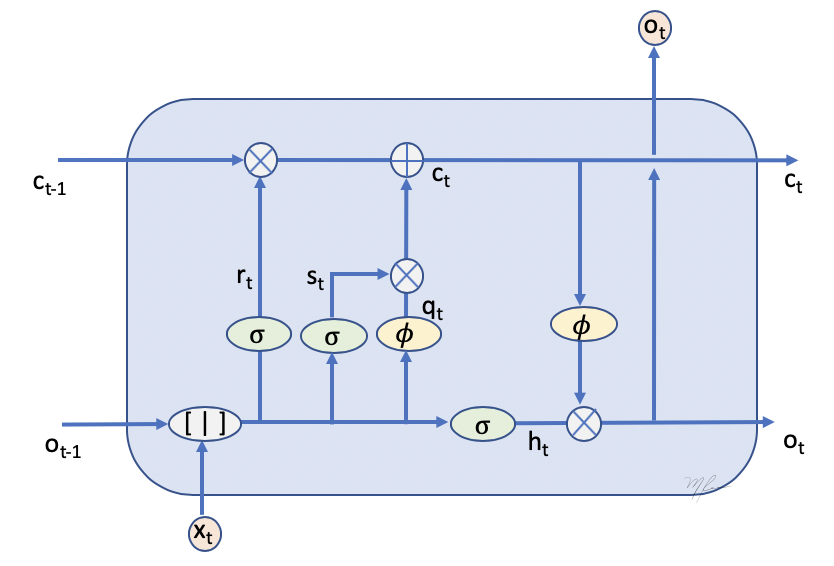

In summary, LSTM networks use a complex structure of gates and memory cells to process sequential data and remember long-term information.



In [13]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True))
model_lstm.add(LSTM(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False))
model_lstm.add(Dense(32, activation='elu'))
model_lstm.add(Dense(16, activation='gelu'))
model_lstm.add(Dense(train_y.shape[1]))

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             19712     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 33,780
Trainable params: 33,780
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_dir = '/kaggle/working/saved_models_lstm'
os.mkdir(model_dir)

In [14]:
#borrar todos los archivos del directorio /kaggle/working/saved_models_lstm
for i in os.listdir(model_dir):
    file_path = os.path.join(model_dir, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [17]:
model_dir_per_epoc = os.path.join(model_dir, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checpoint = ModelCheckpoint(model_dir_per_epoc, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=0)

calbacks = [checpoint]

In [19]:
history = {'loss':[], 'val_loss':[]}
with tqdm(total=500) as pbar:
    for i in range(500):
        h = model_lstm.fit(train_x, train_y,
                    epochs = 1,
                    batch_size = 16,
                    validation_split=0.1,
                    callbacks=calbacks,
                    shuffle=False,
                    verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)


print('Valores de la ultima epoca: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

100%|██████████| 500/500 [02:58<00:00,  2.80it/s]

Valores de la ultima epoca: 
loss:  [47.80210876464844]
val_loss:  [11012.2880859375]


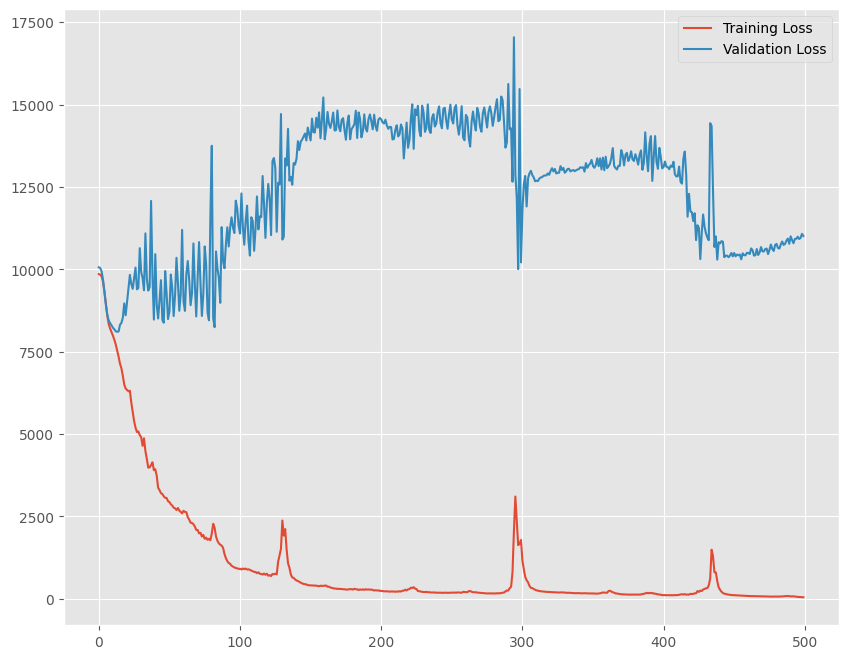

In [24]:
loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [28]:
models_dir = os.path.join(model_dir, os.listdir(model_dir)[-5])
model = keras.models.load_model(models_dir)

predictions = model.predict(test_x)
predictions_lstm = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_lstm

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

1/1 [==============================] - 1s 1s/step
MSE:  16063.866991989187
RMSE:  126.74331142900279
MAE:  67.60235686335325


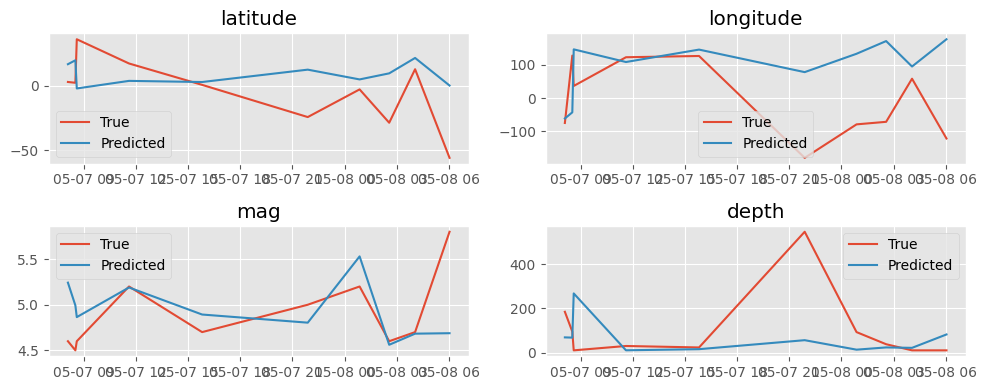

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_lstm.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()


<a id="b"></a>
### b) Vanilla RNN:

Input:
Like in LSTM networks, input in an RNN is processed sequentially over time. At each time step $t$, the network receives an input $x_t$, which can be a vector or a matrix, depending on the type of problem being tackled.

Hidden state:
While processing the input at each time step, the network generates a hidden state $h_t$, which is used to generate the output at that same time step, as well as to feed into the next iteration of the network. The hidden state is an internal representation of the information processed up until that moment.

Activation function:
In a simple RNN, the activation function used in the hidden layer is the sigmoid function or the hyperbolic tangent function.

Computation of the hidden state:
The hidden state is computed using the following formula:

\begin{equation}
h_t = \sigma(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
\end{equation}

where $W_{xh}$ and $W_{hh}$ are the weight matrices that multiply the input and the previous hidden state, respectively, and $b_h$ is the bias vector.

Output generation:
The output at each time step is generated from the current hidden state. There may be an additional output layer that transforms the hidden state into the desired format for the problem at hand.

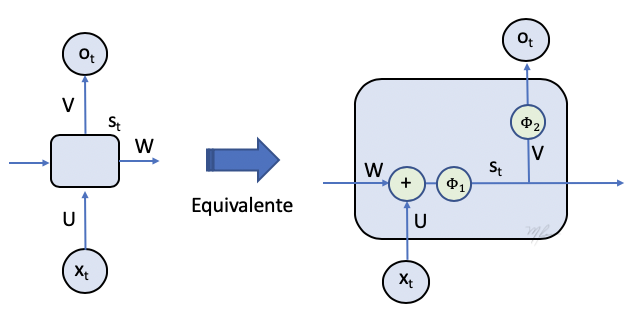

In summary, simple recurrent neural networks process input sequentially over time and generate a hidden state that is used to generate output and feed into the next iteration of the network.

In [33]:
#modelo RNN 

model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True))
model_rnn.add(SimpleRNN(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False))
model_rnn.add(Dense(32, activation='elu'))
model_rnn.add(Dense(16, activation='gelu'))
model_rnn.add(Dense(train_y.shape[1]))

model_rnn.compile(optimizer='adam', loss='mse')

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 64)             4928      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 9,684
Trainable params: 9,684
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_dir = '/kaggle/working/saved_models_rnn'
os.mkdir(model_dir)

In [34]:
#borrar todos los archivos del directorio /kaggle/working/saved_models_rnn
for i in os.listdir(model_dir):
    file_path = os.path.join(model_dir, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [35]:
model_dir_per_epoc = os.path.join(model_dir, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checpoint = ModelCheckpoint(model_dir_per_epoc, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=0)

calbacks = [checpoint]

In [36]:
history = {'loss':[], 'val_loss':[]}
with tqdm(total=500) as pbar:
    for i in range(500):
        h = model_rnn.fit(train_x, train_y,
                    epochs = 1,
                    batch_size = 16,
                    validation_split=0.1,
                    callbacks=calbacks,
                    shuffle = False,
                    verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)


print('Valores de la ultima epoca: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])


100%|██████████| 500/500 [04:38<00:00,  1.80it/s]

Valores de la ultima epoca: 
loss:  [141.13247680664062]
val_loss:  [12801.9580078125]


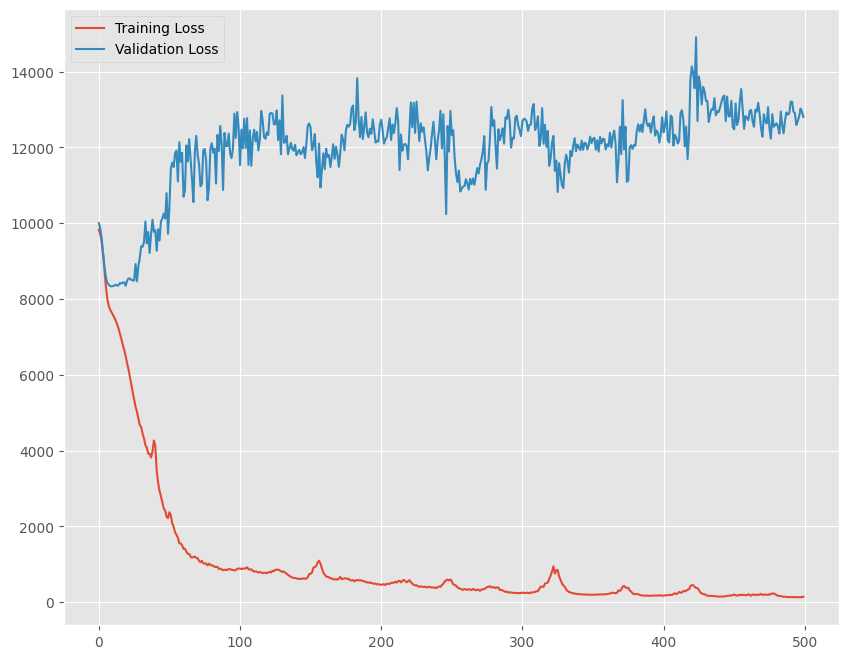

In [37]:
loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

#graficar las perdidas y el mae, con cada puntos en cada epoca
plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [40]:
models_dir = os.path.join(model_dir, os.listdir(model_dir)[-5])
model = keras.models.load_model(models_dir)

predictions = model.predict(test_x)
predictions_rnn = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_rnn

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

1/1 [==============================] - 0s 229ms/step
MSE:  22091.320979356078
RMSE:  148.6314939013804
MAE:  87.9812819585693


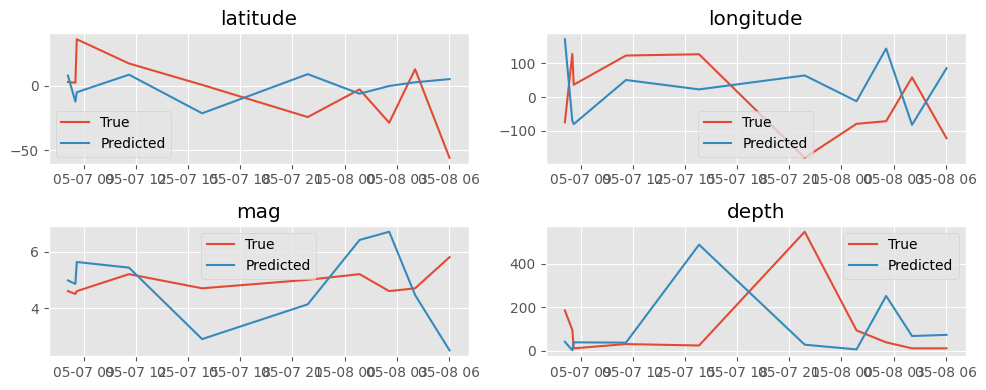

In [41]:
# Graficar las predicciones contra los datos reales
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_rnn.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_rnn[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()

<a id="c"></a>
### c) GRU Model

GRUs are a type of recurrent neural network (RNN) that were introduced as a simplified version of the LSTM. Like LSTMs, GRUs can capture long-term dependencies in sequential data by processing input sequentially through time and using a hidden state to maintain a representation of the information seen so far.

However, unlike LSTMs, GRUs use a simpler gating mechanism to control the flow of information between the hidden state and the input. Specifically, GRUs use a single "reset gate" and "update gate" to selectively decide which parts of the hidden state to keep and which parts to update with new input.

The reset gate controls how much of the previous hidden state should be forgotten, while the update gate controls how much of the new input should be incorporated into the hidden state. These gates are controlled by sigmoid activation functions, allowing the model to learn to selectively update and forget information.

Input:
As with Simple RNN and LSTM, input in a GRU is processed sequentially over time. At each time step $t$, the network receives an input $x_t$, which can be a vector or a matrix, depending on the type of problem being addressed.

Hidden state:
When processing the input at each time step, the network generates a hidden state $h_t$, which is used to generate the output at that same time step, as well as to feed the next iteration of the network. The hidden state is an internal representation of the information processed up to that point.

Update Gate:
The update gate $z_t$ determines how much of the previous hidden state $h_{t-1}$ should be kept for the current time step and how much of the new candidate activation $\tilde{h}_t$ should be added. The update gate is calculated using the sigmoid function:

\begin{equation}
z_t = \sigma(W_{xz}x_t + W_{hz}h_{t-1} + b_z)
\end{equation}

where $W_{xz}$ and $W_{hz}$ are the weight matrices that multiply the input and the previous hidden state, respectively, and $b_z$ is the bias vector.

Reset Gate:
The reset gate $r_t$ determines how much of the previous hidden state $h_{t-1}$ should be forgotten and how much of the new candidate activation $\tilde{h}_t$ should be added. The reset gate is calculated using the sigmoid function:

\begin{equation}
r_t = \sigma(W_{xr}x_t + W_{hr}h_{t-1} + b_r)
\end{equation}

where $W_{xr}$ and $W_{hr}$ are the weight matrices that multiply the input and the previous hidden state, respectively, and $b_r$ is the bias vector.

Candidate Activation:
The candidate activation $\tilde{h}_t$ is the new proposed hidden state based on the input and the previous hidden state. It is calculated using the hyperbolic tangent function:

\begin{equation}
\tilde{h}t = \tanh(W{xh}x_t + r_t \odot W_{hh}h_{t-1} + b_h)
\end{equation}

where $\odot$ represents the element-wise product.

Final Hidden State:
The final hidden state $h_t$ is a combination of the previous hidden state and the candidate activation, weighted by the update gate:

\begin{equation}
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{equation}

A graphical representation of this, is in the next picture:

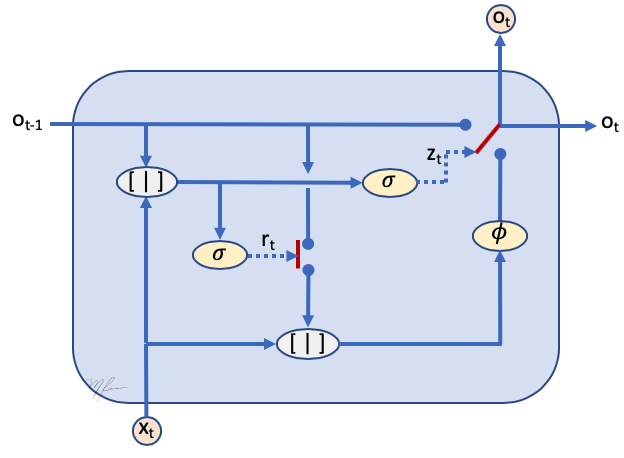

In [42]:
#modelo GRU 
model_gru = Sequential()
model_gru.add(GRU(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True))
model_gru.add(GRU(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False))
model_gru.add(Dense(32, activation='elu'))
model_gru.add(Dense(16, activation='gelu'))
model_gru.add(Dense(train_y.shape[1]))

model_gru.compile(optimizer='adam', loss='mse')

model_gru.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 64)             14976     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 4)                 68        
                                                                 
Total params: 26,036
Trainable params: 26,036
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_dir = '/kaggle/working/saved_models_gru'
os.mkdir(model_dir)

In [44]:
#borrar todos los archivos del directorio /kaggle/working/saved_models_gru
for i in os.listdir(model_dir):
    file_path = os.path.join(model_dir, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [45]:
model_dir_per_epoc = os.path.join(model_dir, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checpoint = ModelCheckpoint(model_dir_per_epoc, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=0)

calbacks = [checpoint]

In [46]:
history = {'loss':[], 'val_loss':[]}
with tqdm(total=500) as pbar:
    for i in range(500):
        h = model_gru.fit(train_x, train_y,
                    epochs = 1,
                    batch_size = 16,
                    validation_split=0.1,
                    callbacks=calbacks,
                          shuffle = False,
                    verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)


print('Valores de la ultima epoca: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

100%|██████████| 500/500 [02:51<00:00,  2.92it/s]

Valores de la ultima epoca: 
loss:  [74.03140258789062]
val_loss:  [10961.8779296875]


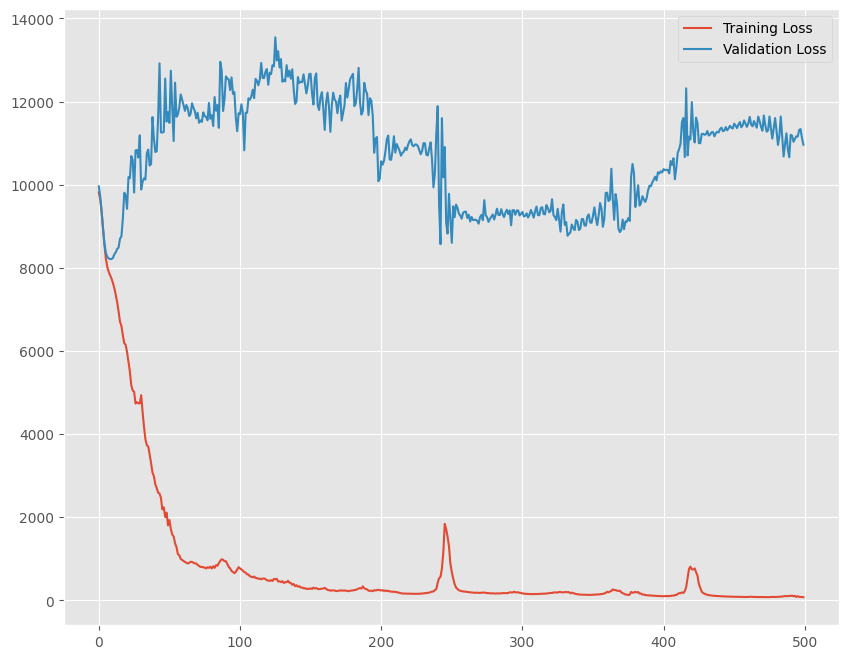

In [47]:
loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

#graficar las perdidas y el mae, con cada puntos en cada epoca
plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [48]:
models_dir = os.path.join(model_dir, os.listdir(model_dir)[-200])
model = keras.models.load_model(models_dir)

predictions = model.predict(test_x)
predictions_gru = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_gru

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

1/1 [==============================] - 1s 621ms/step
MSE:  13985.175069936518
RMSE:  118.25893230507587
MAE:  64.7799656022358


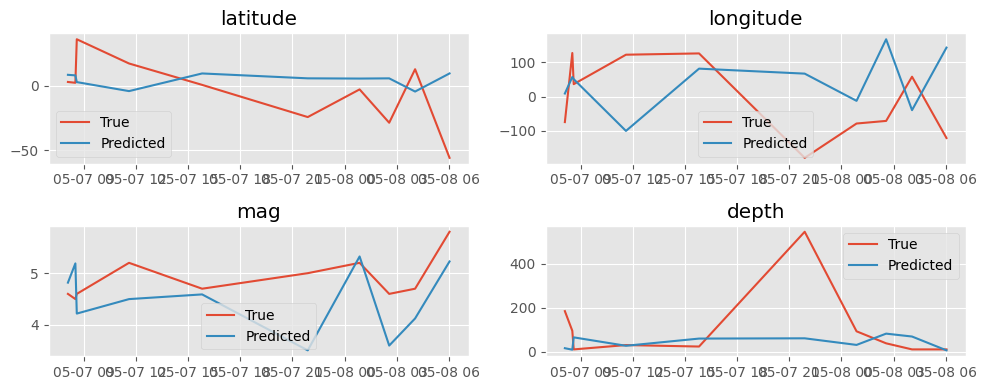

In [49]:
# Graficar las predicciones contra los datos reales
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_gru[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()

<a id="d"></a>
### d) LSTM Bidirectional Model

Bidirectional neural networks are a variant of recurrent neural networks that process the input in both directions: from the past to the future and from the future to the past. This allows the network to access information from both previous and future contexts for each time step, which can improve performance on tasks that require a wider context.

The bidirectional network consists of two recurrent layers: one layer that processes the input in temporal order and another layer that processes the input in reverse order. At each time step $t$, the output of both layers is concatenated and fed through an additional output layer.

The mathematical representation of a bidirectional network can be expressed as:

\begin{equation}
\overrightarrow{h_t} = f(\overrightarrow{x_t}, \overrightarrow{h_{t-1}})
\end{equation}

\begin{equation}
\overleftarrow{h_t} = g(\overleftarrow{x_t}, \overleftarrow{h_{t+1}})
\end{equation}

where $\overrightarrow{h_t}$ is the hidden state at time step $t$ in the recurrent layer that processes the input in temporal order, $\overleftarrow{h_t}$ is the hidden state at time step $t$ in the recurrent layer that processes the input in reverse order, $\overrightarrow{x_t}$ and $\overleftarrow{x_t}$ are the inputs at time step $t$ in both layers, $f$ and $g$ are the activation functions in each layer.

The output of the bidirectional network can be calculated as:

\begin{equation}
y_t = h_t = hconcat(\overrightarrow{h_t}, \overleftarrow{h_t})
\end{equation}

where $hconcat$ is the concatenation function that combines the hidden states of both layers.

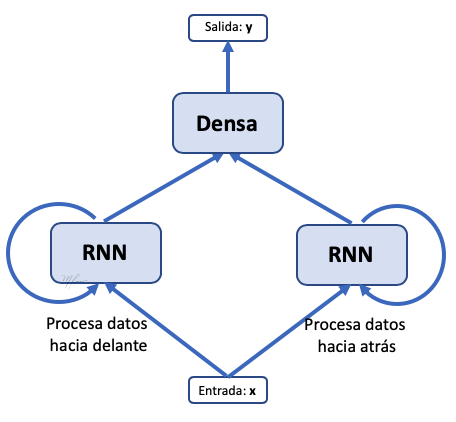

In [50]:
#modelo bidireccional
model_bid_lstm = Sequential()
model_bid_lstm.add(Bidirectional(LSTM(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True)))
model_bid_lstm.add(Bidirectional(LSTM(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False)))
model_bid_lstm.add(Dense(32, activation='elu'))
model_bid_lstm.add(Dense(16, activation='gelu'))
model_bid_lstm.add(Dense(train_y.shape[1]))

model_bid_lstm.compile(optimizer='adam', loss='mse')

model_bid_lstm.build(input_shape=(None, n_features, n_input))
model_bid_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 4, 128)           39424     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 83,316
Trainable params: 83,316
Non-trai

In [51]:
model_dir = '/kaggle/working/saved_models_bid_lstm'
os.mkdir(model_dir)

In [52]:
#borrar todos los archivos del directorio /kaggle/working/saved_models_bid_lstm
for i in os.listdir(model_dir):
    file_path = os.path.join(model_dir, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [53]:
model_dir_per_epoc = os.path.join(model_dir, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checpoint = ModelCheckpoint(model_dir_per_epoc, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=0)

calbacks = [checpoint]

In [54]:
history = {'loss':[], 'val_loss':[]}
with tqdm(total=500) as pbar:
    for i in range(500):
        h = model_bid_lstm.fit(train_x, train_y,
                    epochs = 1,
                    batch_size = 16,
                    validation_split=0.1,
                    callbacks=calbacks,
                    shuffle =False,
                    verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)


print('Valores de la ultima epoca: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

100%|██████████| 500/500 [03:38<00:00,  2.28it/s]

Valores de la ultima epoca: 
loss:  [26.118921279907227]
val_loss:  [13113.259765625]


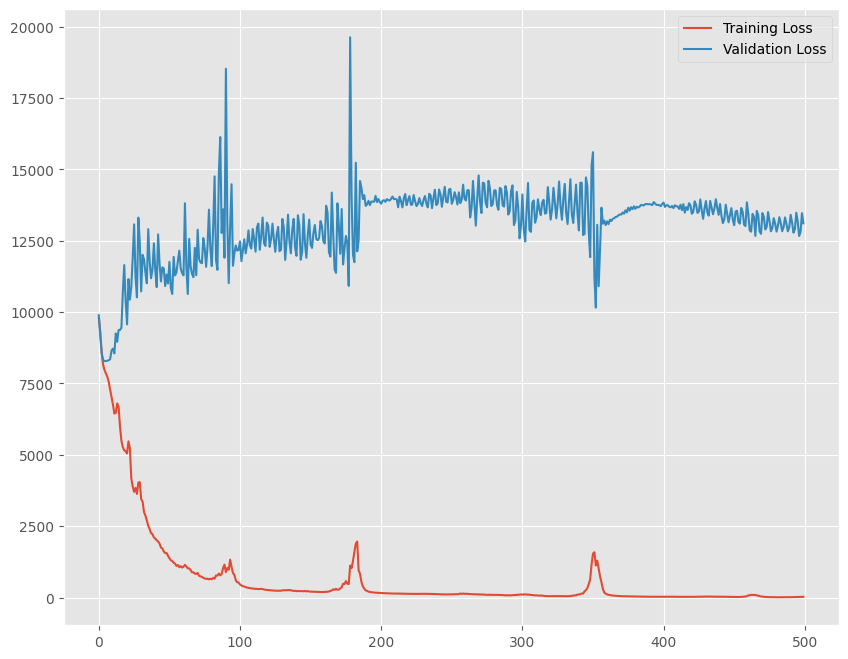

In [55]:
loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

#graficar las perdidas y el mae, con cada puntos en cada epoca
plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [56]:
models_dir = os.path.join(model_dir, os.listdir(model_dir)[-10])
model = keras.models.load_model(models_dir)

predictions = model.predict(test_x)
predictions_bid_lstm = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_bid_lstm

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

1/1 [==============================] - 1s 1s/step
MSE:  12809.303574036916
RMSE:  113.1781938981044
MAE:  62.690112164425855


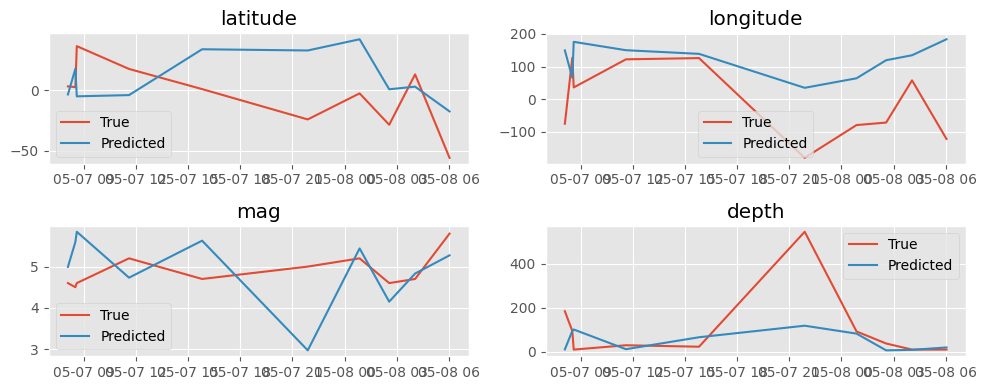

In [58]:
# Graficar las predicciones contra los datos reales
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_bid_lstm.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_bid_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()

<a id="6"></a>
# 6. Evaluating Models Output


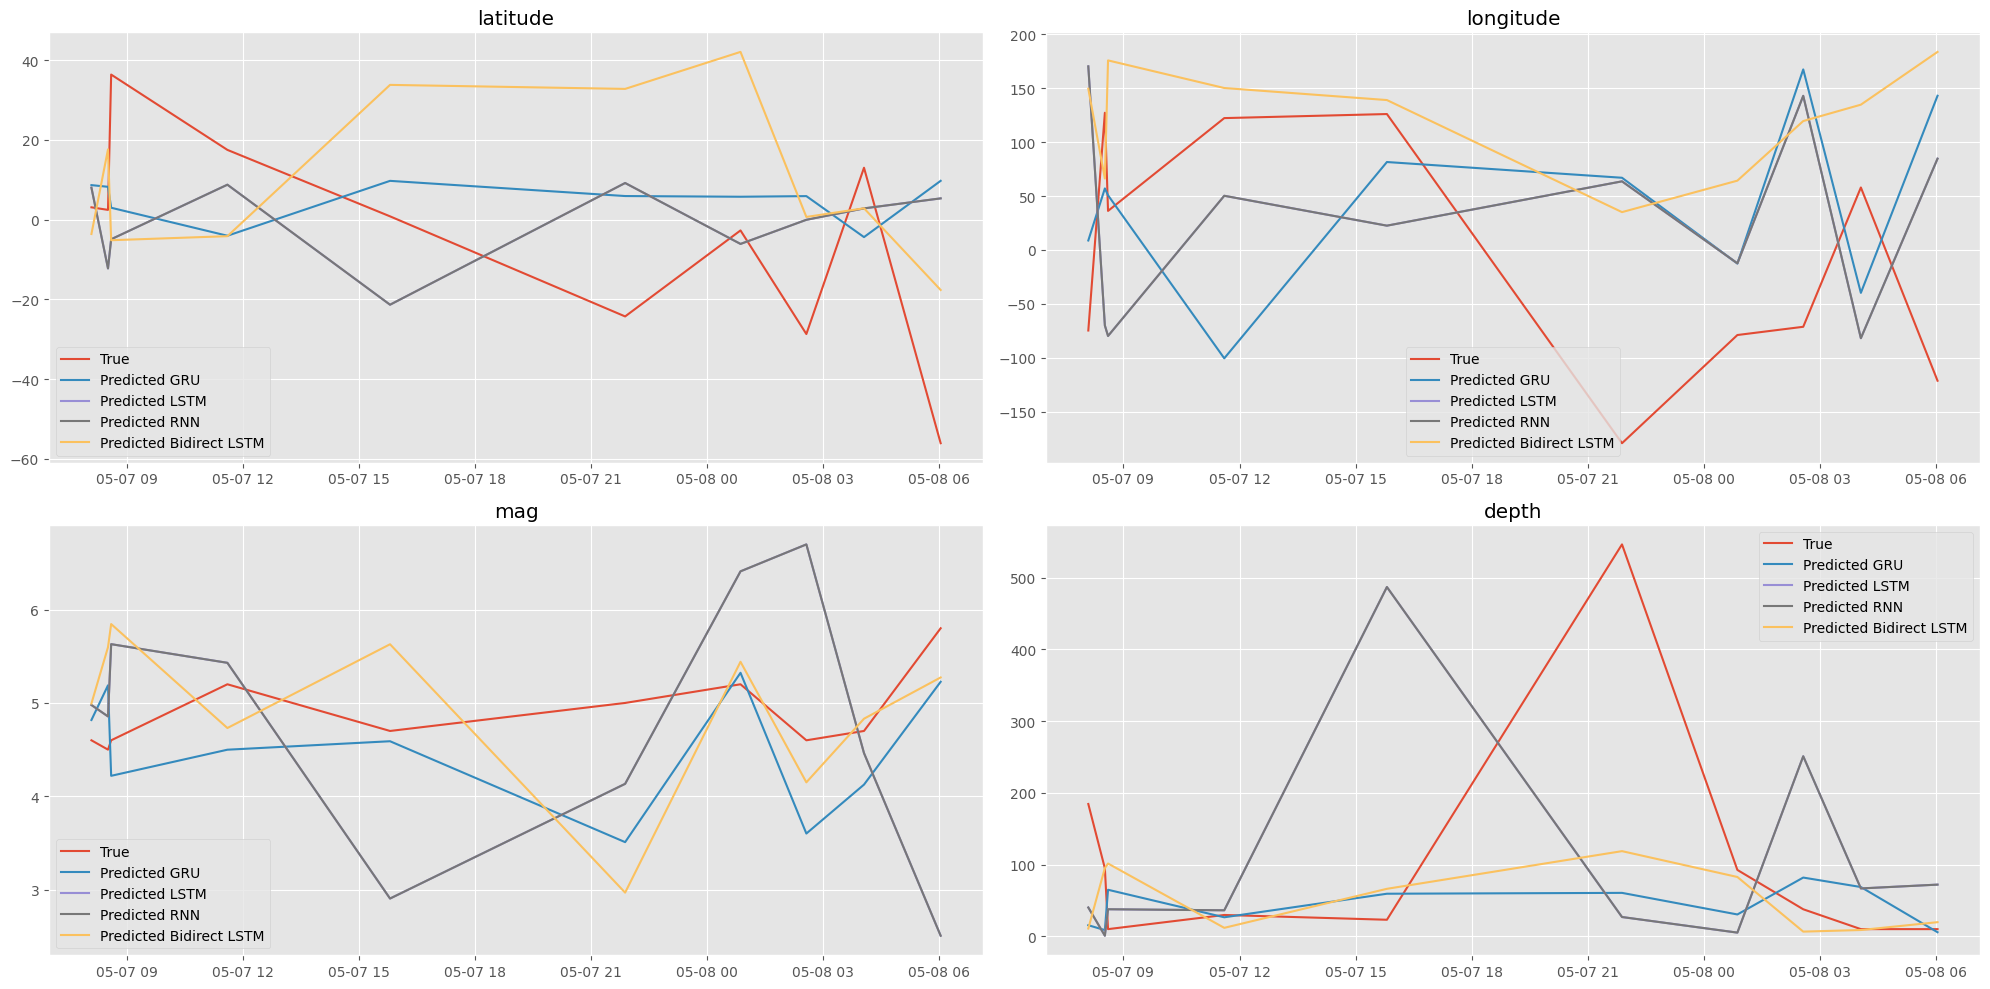

In [59]:
#Realizar una grafica que muestre las predicciones de los 3 modelos en una misma grafica

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_gru[col], label='Predicted GRU')
    ax[i//2, i%2].plot(predictions_lstm[col], label='Predicted LSTM')
    ax[i//2, i%2].plot(predictions_rnn[col], label='Predicted RNN')
    ax[i//2, i%2].plot(predictions_bid_lstm[col], label='Predicted Bidirect LSTM')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()

## I hope you liked it, give an upvote in that case :)